# BigQuery Commands

Google Cloud Datalab provides a first class experience for working with Google BigQuery for both adhoc, exploratory work as well as pipeline development. In addition to authoring and executing SQL queries, you'll likely want to inspect DataSets, Tables, and their Schema, and also sample data.

This notebook introduces various BigQuery commands that Cloud Datalab brings into the notebook environment.

You've already seen the use of `%%sql` in the [Hello BigQuery](Hello BigQuery.ipynb) notebook. The BigQuery commands are invoked using `%%bigquery`.

## Commands, literally

You can think of `%%bigquery` as your command line interface to BigQuery. These commands take arguments, including `--help`, in the same manner as other shell commands. Lets start by looking at help.

In [1]:
%bigquery --help

usage: bigquery [-h]
                {sample,create,delete,dryrun,udf,execute,pipeline,table,schema,datasets,tables,extract,load}
                ...

Execute various BigQuery-related operations. Use "%bigquery <command> -h" for
help on a specific command.

positional arguments:
  {sample,create,delete,dryrun,udf,execute,pipeline,table,schema,datasets,tables,extract,load}
                        commands
    sample              Display a sample of the results of a BigQuery SQL
                        query. The cell can optionally contain arguments for
                        expanding variables in the query, if -q/--query was
                        used, or it can contain SQL for a query.
    create              Create a dataset or table.
    delete              Delete a dataset or table.
    dryrun              Execute a dry run of a BigQuery query and display
                        approximate usage statistics
    udf                 Create a named Javascript BigQuery UDF
    exec

You can get help on any of the individual commands as follows:

In [2]:
%bigquery tables --help

usage: bigquery tables [-h] [-p PROJECT] [-d DATASET] [-f FILTER]

optional arguments:
  -h, --help            show this help message and exit
  -p PROJECT, --project PROJECT
                        The project whose tables should be listed
  -d DATASET, --dataset DATASET
                        The dataset to restrict to
  -f FILTER, --filter FILTER
                        Optional wildcard filter string used to limit the
                        results


# Listing BigQuery Resources

The first thing you might decide to do is list datasets and tables contained within a specified project or the default project you're running this Cloud Datalab environment in.

Note that you will be able to list and use any BigQuery dataset that has been shared with the project (its service account) that you are running Cloud Datalab in.

In [3]:
%bigquery datasets --project cloud-datalab-samples

In [4]:
%bigquery tables --dataset cloud-datalab-samples:httplogs

# Exploring Data

Once you've found a table or set of tables to work with, its simple to retrieve its schema or some sampling of rows to understand the data you're working with.

## Schema

In [5]:
%bigquery schema --table cloud-datalab-samples:httplogs.logs_20140615

## Sample Data

In [6]:
%bigquery sample --help

usage: bigquery sample [-h] [-q QUERY | -t TABLE | -v VIEW] [-c COUNT]
                       [-m {limit,random,hashed,sorted}] [-p PERCENT]
                       [-f FIELD] [-o {ascending,descending}] [-P] [--verbose]

optional arguments:
  -h, --help            show this help message and exit
  -q QUERY, --query QUERY
                        the name of the query to sample
  -t TABLE, --table TABLE
                        the name of the table to sample
  -v VIEW, --view VIEW  the name of the view to sample
  -c COUNT, --count COUNT
                        The number of rows to limit to, if sampling
  -m {limit,random,hashed,sorted}, --method {limit,random,hashed,sorted}
                        The type of sampling to use
  -p PERCENT, --percent PERCENT
                        For random or hashed sampling, what percentage to
                        sample from
  -f FIELD, --field FIELD
                        The field to use for sorted or hashed sampling
  -o {ascending,descending

As you can see, Cloud Datalab allows you to sample a specified count of rows using various sampling strategies, including random sampling or hashing. Let's try retrieving a couple of samples.

In [7]:
%bigquery sample --table cloud-datalab-samples:httplogs.logs_20140615 --count 5

timestamp,latency,status,method,endpoint
2014-06-15 07:00:00.003772,122,200,GET,Interact3
2014-06-15 07:00:00.428897,144,200,GET,Interact3
2014-06-15 07:00:00.536486,48,200,GET,Interact3
2014-06-15 07:00:00.652760,28,405,GET,Interact2
2014-06-15 07:00:00.670100,103,200,GET,Interact3


In [8]:
%bigquery sample --table cloud-datalab-samples:httplogs.logs_20140615 --count 10 --field timestamp --method hashed

timestamp,latency,status,method,endpoint
2014-06-15 07:00:05.449186,6,302,GET,Other
2014-06-15 07:00:05.908400,5,302,GET,Other
2014-06-15 07:00:09.078710,30,405,GET,Interact2
2014-06-15 07:00:18.609836,28,200,GET,Other
2014-06-15 07:00:18.861028,119,200,GET,Other
2014-06-15 07:00:25.316129,712,200,GET,Interact3
2014-06-15 07:00:28.423380,211,404,GET,Other
2014-06-15 07:00:46.074430,501,200,GET,Other
2014-06-15 07:00:51.734565,124,200,GET,Other
2014-06-15 07:00:53.029076,121,405,GET,Interact2


# Querying Data

Of course, since, querying BigQuery data using SQL is the primary scenario, it's always handy to have the BigQuery SQL reference. Cloud Datalab makes this easy to access by providing a direct link to the [query reference](https://cloud.google.com/bigquery/query-reference) via the Help button on the top toolbar.

Lets see an example of this.

In [9]:
%%sql
SELECT timestamp, latency
FROM [cloud-datalab-samples:httplogs.logs_20140615]
ORDER BY latency DESC
LIMIT 10

timestamp,latency
2014-06-15 10:15:06.354093,13500918
2014-06-15 09:15:04.571911,13500391
2014-06-15 10:00:05.264877,13500340
2014-06-15 09:45:04.873233,13500166
2014-06-15 09:30:07.401665,13500118
2014-06-16 00:01:45.311564,1197339
2014-06-15 15:17:12.987435,136467
2014-06-15 15:16:33.290520,130296
2014-06-15 15:15:56.727494,121277
2014-06-15 15:15:58.259215,97192


That was a simple query. Now, let's do something a bit more interesting: let's compute the 50th percentile, 95th percentile, and 99th percentile latencies for request processing.

BigQuery makes this effortless with its built-in statistical and analytics functions, such as `QUANTILES` and `NTH`.

In [10]:
%%sql
SELECT
  NTH(50, quantiles) AS latency_50th_percentile,
  NTH(95, quantiles) AS latency_95th_percentile,
  NTH(99, quantiles) AS latency_99th_percentile
FROM (
  SELECT QUANTILES(latency, 100) AS quantiles
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
)

latency_50th_percentile,latency_95th_percentile,latency_99th_percentile
81,462,15204


# Visualizing Data

Beyond tables, it almost always interesting to be able to visualize the data to get a more meaningful view of aggregates, trends and patterns.

Let's write another query, also using `QUANTILES`. This time, the `ROW_NUMBER` function will be used to also include a row number in the output data representing the percentile, using the number as the chart's x-axis value. In order to reference this SQL query in the chart, it is converted into a SQL module via the `--module` argument. This module can then be passed to the chart by referencing its name. The chart will execute the contained query.

In [11]:
%%sql --module data
SELECT ROW_NUMBER() OVER (ORDER BY time) AS percentile, time
FROM (
  SELECT QUANTILES(LOG10(latency), 50) AS time
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
)

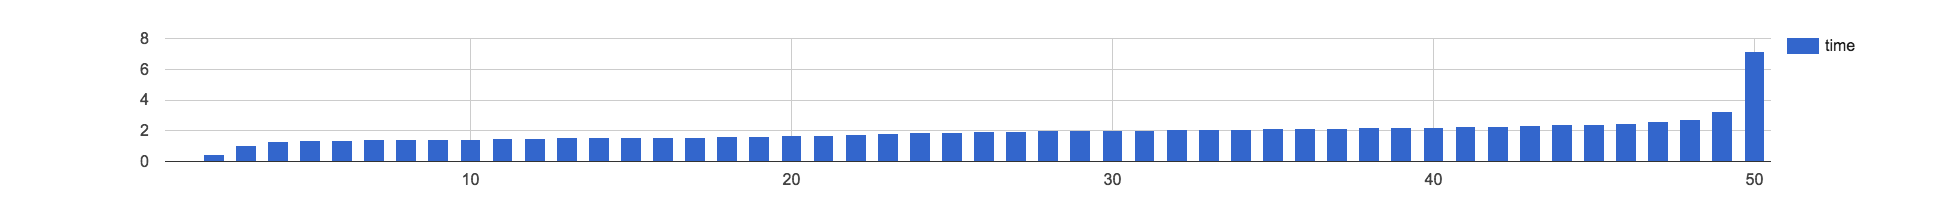

In [12]:
%chart columns --data data --fields percentile,time

# Looking Ahead

There are other commands, such as those that import (load) and export (extract) data or that create pipelines or transform data to build **ETL pipelines**.

Cloud Datalab allows creating **parameterized queries**, which can be modified using variables defined interactively in the notebook  or through pipeline commands during deployment. Queries can be declared and validated one step at a time to create **composite SQL queries** that harness the full power of BigQuery SQL while managing authoring complexity.

All of these BigQuery commands are implemented on top of **Python BigQuery APIs** (in the `gcp.bigquery` Python module). This implementation not only allows you to write arbitrary code and logic while working with BigQuery data, but also lets you integrate SQL and Python, and the Python data analysis libraries such as pandas and matplotlib, to perform sophisticated and custom data analysis and visualization tasks.

These topics are covered in other BigQuery tutorial notebooks that are included with Cloud Datalab.